In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit learn modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder as OHE, LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix, classification_report

# Imbalanced modules
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# TensorFlow & Keras modules
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import(
    LSTM, Dense, Embedding, Dropout,
    Bidirectional, BatchNormalization,   
    Dense, Softmax, Multiply, Lambda, Input)

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Model


In [120]:
# I am using the cleaned dataset which I created in the previous notebook
df = pd.read_csv('Datasets/Cleaned_Tweets.csv')
df.head()

,airline_sentiment,text
0,neutral,what said
1,positive,plus you've added commercials to the experien...
2,neutral,i didn't today must mean i need to take anoth...
3,negative,it's really aggressive to blast obnoxious ent...
4,negative,and it's a really big bad thing about it


In [121]:
df.head()

,airline_sentiment,text
0,neutral,what said
1,positive,plus you've added commercials to the experien...
2,neutral,i didn't today must mean i need to take anoth...
3,negative,it's really aggressive to blast obnoxious ent...
4,negative,and it's a really big bad thing about it


In [122]:
df.shape

(14640, 2)

In [123]:
df['airline_sentiment'].value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

## PreProcessing 

In [124]:
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['text'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['text'])

In [125]:
# Padding sequences to make them of equal length
MAX_LEN = 34
padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN ,truncating='post')

In [126]:
X = padded_sequences
y = df['airline_sentiment']

In [127]:
y.head()

0     neutral
1    positive
2     neutral
3    negative
4    negative
Name: airline_sentiment, dtype: object

In [128]:
# encoding the target variable and converting it to numpy array
le = LabelEncoder()
y = le.fit_transform(y)

y = to_categorical(y, num_classes=3)

In [129]:
y

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], shape=(14640, 3))

In [ ]:
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X, y)

In [131]:
# Save the categories into a list 
categories = list(np.unique(df['airline_sentiment']))       
categories

['negative', 'neutral', 'positive']

In [132]:
y.shape 

(27534, 3)

In [133]:
X.shape

(27534, 34)

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [135]:
print(X_train.shape, X_test.shape)  

(22027, 34) (5507, 34)


In [136]:
print(y_train.shape, y_test.shape)  

(22027, 3) (5507, 3)


## Model Structure

In [137]:
# Model parameters 
EMBEDDING_DIM = 100
VOCAB_SIZE = len(tokenizer.word_index) + 1

**I am planning to use the Functional API , that models are going to built by connecting layers sequentially, where each layer’s output becomes the input to the next**<br>
**The x variable will be like a carrier.**

In [ ]:
# Define input
inputs = Input(shape=(MAX_LEN,))

# Embedding
x = Embedding(VOCAB_SIZE, EMBEDDING_DIM)(inputs)

# First BiLSTM:
# I am aiming to use BiLSTM model that 
# I am gonna use 34 units for the BiLSTM layer per direction. total 64 features 32 backward and 32 forward  
x = Bidirectional(LSTM(34, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))(x)
# Since the model is easy to overfit, I went to use 0.5 dropout rate for the BiLSTM layer
# I use Batch Normalization for stabilizing the process
#x = BatchNormalization()(x)

# Second BiLSTM: 
# I am gonna use 32 units for the BiLSTM layer per direction. total 64 features  
x = Bidirectional(LSTM(34, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))(x)
#x = BatchNormalization()(x)


#----------------------------------------------------------------
# Attention Mechanism:

# I am gonna use self attention mechanism to find the most important words in the sentence
# Computing thr score 
attention_scores = Dense(1, activation=None)(x)
# Normalizing attention weights
attention_weights = Softmax(axis=1)(attention_scores)
# Applying th weights 
context_vector = Multiply()([x, attention_weights])
context_vector = Lambda(lambda x: tf.reduce_sum(x, axis=1))(context_vector)

# I am not sure that this is the correct way to implement the attention mechanism, because it is not effective on the model's performance
# I got this syntax from Grok, in below is syntax code, what I got from Grok:
"""
attention = layers.Dense(1, activation='tanh')(lstm_output)
attention = layers.Flatten()(attention)
attention = layers.Activation('softmax')(attention)
attention = layers.Reshape((max_len, 1))(attention)

# Apply attention
attn_output = layers.multiply([lstm_output, attention])
attn_output = layers.Lambda(lambda x: K.sum(x, axis=1))(attn_output)
"""
# I did not use tanh activation function, because it's range is between -1,1, -1 might squashes the attention scores 
# Reshape the attention weights is not necessary, because in  https://stackoverflow.com/questions/49977236/tensorflow-broadcasting
# In Stack overflow, I found: Broadcasting is the process of making arrays with different shapes have compatible shapes for arithmetic operations. 
# I used tf.reduce_sum to sum the values instead of K.sum, There is no difference between them. 
#---------------------------------------------------------------------

# Output layer: 
outputs = Dense(3, activation='softmax')(context_vector)

model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 34, 100)   │  1,455,500 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_10    │ (None, 34, 68)    │     36,720 │ embedding_5[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_11    │ (None, 34, 68)    │     28,016 │ bidirectional_10… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 34, 1)     │         69 │ bidirectional_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_3 (Softmax) │ (None, 34, 1)     │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 34, 68)    │          0 │ bidirectional_11… │
│ (Multiply)          │                   │            │ softmax_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 68)        │          0 │ multiply_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 3)         │        207 │ lambda_3[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,520,512 (5.80 MB)

 Trainable params: 1,520,512 (5.80 MB)

 Non-trainable params: 0 (0.00 B)

In [139]:
# Define callbacks: Early stopping and learning rate reducer
early_stop = EarlyStopping(
monitor='val_loss',
patience=3, 
restore_best_weights=True,
verbose=1,
mode='max')

lr_reducer = ReduceLROnPlateau(monitor='val_loss', 
factor=0.2 , patience=2, verbose=1)

history = model.fit(X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, lr_reducer]
)

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 126s 166ms/step - accuracy: 0.5655 - loss: 0.8680 - val_accuracy: 0.8166 - val_loss: 0.4723 - learning_rate: 0.0010
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 101s 147ms/step - accuracy: 0.8458 - loss: 0.4177 - val_accuracy: 0.8553 - val_loss: 0.3908 - learning_rate: 0.0010
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 89s 130ms/step - accuracy: 0.8953 - loss: 0.3067 - val_accuracy: 0.8711 - val_loss: 0.3640 - learning_rate: 0.0010
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 96s 139ms/step - accuracy: 0.9134 - loss: 0.2495 - val_accuracy: 0.8834 - val_loss: 0.3422 - learning_rate: 0.0010
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


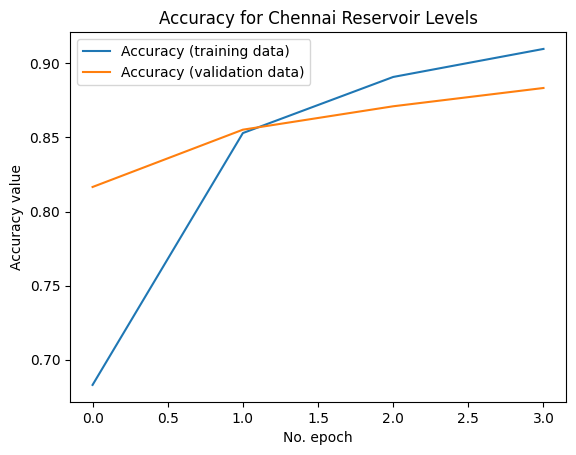

In [ ]:
# Visualizing the model performanc
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Accuracy for Chennai Reservoir Levels')
plt.ylabel('Accuracy value')
plt.xlabel('epochs')
plt.legend(loc="upper left")
plt.show()

**What I saw from visualization and training process, the model is overfitting since training accuracy is higher than validation accuracy.**<br>
**Early  Stopping saved my model from further overfitting.**

In [158]:
# predicting the test data
y_pred = model.predict(X_test)

173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step


In [159]:
# Converting the predicted values to the classes
y_pred = np.argmax(y_pred, axis=1)

In [160]:
# classification report and adding categories as labels
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=categories))

              precision    recall  f1-score   support

    negative       0.86      0.78      0.82      1895
     neutral       0.74      0.81      0.78      1786
    positive       0.85      0.86      0.86      1826

    accuracy                           0.82      5507
   macro avg       0.82      0.82      0.82      5507
weighted avg       0.82      0.82      0.82      5507



**Getting 82% for overall accuracy is not bad, but it is  still lower than Naive Bayes, The precision for the neutral class is low. The model has best performing for Positive class.**